In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth

In [1]:
from unsloth import FastLanguageModel
from datasets import Dataset

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import torch
import json

## Overview

In [2]:
train_df = pd.read_excel('/content/drive/MyDrive/DIP_V2_AdditionalData/train_set.xlsx', index_col='ID')
test_df = pd.read_excel('/content/drive/MyDrive/DIP_V2_AdditionalData/test_set.xlsx', index_col='ID')

print(train_df.shape, test_df.shape)
train_df.head()

(37447, 3) (8392, 3)


,NAME,ENG,THA
ID,,,
1,25,"Clothing, namely, blousons, dress shirts, shir...",เครื่องแต่งกาย ได้แก่ เสื้อแจ๊คเก็ตสั้นถึงเอว ...
2,25,"headgear, namely, bonnets, headscarves, beanie...",เครื่องคลุมศีรษะ ได้แก่ หมวกปีกกว้างสตรีที่มีส...
3,25,"waterproof clothing, namely, vests",ชุดกันน้ำ ได้แก่ เสื้อกั๊ก
4,25,veils being clothing,ผ้าคลุมที่เป็นเครื่องแต่งกาย
5,25,Valenki being felted boots,รองเท้ากันหนาวที่เป็นรองเท้าบูทขนสัตว์


In [3]:
with open('/content/drive/MyDrive/DIP_V2_AdditionalData/WIPO.json', 'r') as f:
    wipo_data = json.load(f)

wipo_data = {int(k): v for k, v in wipo_data.items()}
wipo_data[1]

'Chemicals for use in industry, science and photography, as well as in agriculture, horticulture and forestry; unprocessed artificial resins, unprocessed plastics; fire extinguishing and fire prevention compositions; tempering and soldering preparations; substances for tanning animal skins and hides; adhesives for use in industry; putties and other paste fillers; compost, manures, fertilizers; biological preparations for use in industry and science.'

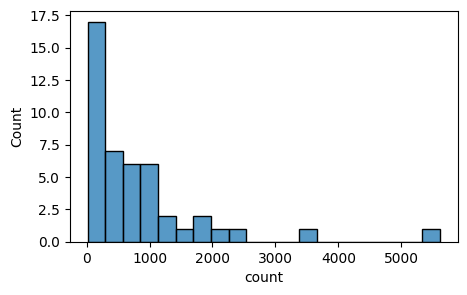

In [4]:
# print(np.sort(train_df['NAME'].unique()))
# all(np.sort(train_df['NAME'].unique()) == np.sort(test_df['NAME'].unique()))

plt.figure(figsize=(5, 3))
sns.histplot(train_df['NAME'].value_counts(), bins=20)
plt.show()

## Data Prep

In [5]:
def sample_by_name(df, n_samples=500):
    sampled_df = pd.DataFrame()
    for name in df['NAME'].unique():
        name_df = df[df['NAME'] == name]
        if len(name_df) > n_samples:
            sampled_df = pd.concat([sampled_df, name_df.sample(n_samples, random_state=42)])
        else:
            sampled_df = pd.concat([sampled_df, name_df])
    return sampled_df

train_df_sampled = sample_by_name(train_df)
train_df_sampled.reset_index(drop=True, inplace=True)
print(train_df_sampled.shape)
train_df_sampled.head()

(16338, 3)


,NAME,ENG,THA
0,25,clothing for motorists and travellers,เครื่องแต่งกายสำหรับผู้ขับขี่มอเตอร์ไซค์และนัก...
1,25,thermal suits,ชุดสูทที่สามารถรักษาอุณหภูมิ
2,25,"water sports suits, namely wetsuits and dry su...","ชุดเล่นกีฬาทางน้ำ ได้แก่ เวทสูท, และดรายสูทสำห..."
3,25,"boots, not for sports",รองเท้าบูทที่ไม่ใช้ใส่เล่นกีฬา
4,25,fancy-dress costumes,ชุดงานแฟนซี


In [6]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Perform machine translation from English to Thai.

Think about the domain of the text to ensure the translation is appropriate.
Consider about this domain:
{}

### Input:
{}

### Response:
{}"""

def formatting_prompt(df):
    batch = []
    for _, row in tqdm(df.iterrows()):
        src, dest = row['ENG'], row['THA']
        prompt = alpaca_prompt.format(wipo_data[row['NAME']], src, dest)
        batch.append({'text': prompt})

    return Dataset.from_list(batch)

train_set = formatting_prompt(train_df_sampled)
test_set = formatting_prompt(test_df)
print(train_set['text'][0])

16338it [00:00, 21057.75it/s]
8392it [00:00, 22511.34it/s]


Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Perform machine translation from English to Thai.

Think about the domain of the text to ensure the translation is appropriate. 
Consider about this domain:
Clothing, footwear, headwear.

### Input:
clothing for motorists and travellers

### Response:
เครื่องแต่งกายสำหรับผู้ขับขี่มอเตอร์ไซค์และนักท่องเที่ยว


## Model Training

In [8]:
model, tokenizer = FastLanguageModel.from_pretrained(
    "ByteDance-Seed/Seed-X-Instruct-7B",
    load_in_8bit=False,
    load_in_4bit=True,
    max_seq_length=1024,
    device_map="auto",
)

==((====))==  Unsloth 2025.8.1: Fast Mistral patching. Transformers: 4.54.0.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/15.0G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


ByteDance-Seed/Seed-X-Instruct-7B does not have a padding token! Will use pad_token = <unk>.


In [11]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "lm_head"],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth: Offloading output_embeddings to disk to save VRAM


Not an error, but Unsloth cannot patch MLP layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2025.8.1 patched 32 layers with 32 QKV layers, 32 O layers and 0 MLP layers.


Unsloth: Training lm_head in mixed precision to save VRAM


In [15]:
from trl import SFTConfig, SFTTrainer

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_set,
    dataset_text_field = "text",
    max_seq_length = 2048,
    packing = True, # Can make training 5x faster for short sequences.
    args = SFTConfig(
        per_device_train_batch_size = 32,
        gradient_accumulation_steps = 2,
        gradient_checkpointing=True,
        warmup_steps = 5,
        # max_steps = 60,
        num_train_epochs = 1,
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",
    ),
)

train_stats = trainer.train()

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/16338 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 16,338 | Num Epochs = 1 | Total steps = 256
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 2 x 1) = 64
 "-____-"     Trainable parameters = 280,973,312 of 7,795,245,056 (3.60% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.265800
2,2.349900
3,2.158500
4,1.698400
5,1.445000
6,0.986300
7,0.807000
8,0.716100
9,0.650500
10,0.538400


In [19]:
from google.colab import userdata

# Merge to 16bit
if False:
    model.save_pretrained_merged("SeedX-DIP", tokenizer, save_method="merged_16bit",)
if True: # Pushing to HF Hub
    model.push_to_hub_merged("PaweekornSora/SeedX-DIP", tokenizer, save_method = "merged_16bit", token=userdata.get("HF_ADMIN"))

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Successfully copied all 1 files from cache to PaweekornSora/SeedX-DIP.


Unsloth: Merging weights into 16bit:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ornSora/SeedX-DIP/model.safetensors:   0%|          |  607kB / 15.0GB            

Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [05:23<00:00, 323.14s/it]
